# Klassifikation - Kopie, Berechnungen mit Median anstelle von Mean!!!

In diesem Notebook werden verschiedene Klassifikationsmodelle trainiert. Ziel ist es, die Städte im Datensatz aufgrund ihrer Feinstaubbelastung in zwei Klassen einzuteilen. Als Zielvariable wird also die Belastung mit mittelgroßen Feinstaubpartikeln (PM2.5, gemessen in µg/m³) angesetzt. 

Als Schwellenwert werden zwei Ansätze getestet:
1. WHO-Richtline von 5 µg/m³: fachlicher Standard
2. Median: datengetriebene Größe

Als Modelle werden verglichen:
1. Logistische Regression
2. Random Forest
3. Gradient Boosting

Verwendet werden verschiedene Module der Python Bibliothek **Scitkit-learn** für maschinelles Lernen

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)

Frage an wer auch immer sich angesprochen fühlt:
Was ist sinnvoller: als Mittelwert für die Schadstoffbelastung einer Stadt den Mean oder den Median nehmen? Hat beides Vor- und Nachteile. Hier wurde der Mean genommen. Aber man sollte vielleicht alles nochmal mit dem Median rechnen und schauen, ob sich die Genauigkeit der Klassifikationsmodelle dadurch verändert.

## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Vollständige Schadstoffmessungen und geographische Verteilung](#1-vollständige-schadstoffmessungen-und-geographische-verteilung)
- [2. Clusterberechnung - mehrstufig](#2-clusterberechnung-mehrstufig)
- [3. Clusterbeschreibung mit PCA](#3-clusterbeschreibung-mit-pca)
- [4. Geographische Verteilung der Schadstoffcluster](#4-geographische-verteilung-der-schadstoffcluster)
- [5. Inhaltliche Interpretation](#5-inhaltliche-interpretation)


# 0. Datensatz laden

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


In [3]:
# Liste relevanter Schadstoffe
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

# Mittelwerte pro Stadt berechnen (Index = City)
df_median = df.groupby('City')[pollutants].median()


In [4]:
df_median.head()

,Co,No2,O3,Pm10,Pm25,So2
City,,,,,,
Abha,6.0,1.0,29.0,10.0,NaN,2.0
Abidjan,NaN,NaN,NaN,NaN,65.0,NaN
Abu dhabi,0.1,10.8,27.3,71.0,93.0,5.1
Accra,NaN,NaN,NaN,NaN,61.0,NaN
Adana,3.3,9.0,14.9,30.0,68.0,3.7


## 🧾 Definition der Zielvariable AirQualityLabel

Um ein Klassifikationsmodell zur Vorhersage der Luftqualität von Städten zu erstellen, wurde eine zielvariable AirQualityLabel eingeführt. Diese ordnet jeder Stadt eine von zwei Klassen zu:

- 0 → Gute Luftqualität

- 1 → Schlechte Luftqualität

Die Einteilung basiert auf dem Medianwert der durchschnittlichen PM2.5-Konzentration aller Städte im Datensatz. Der Median wurde als datengetriebener Grenzwert gewählt, da sich der offiziell empfohlene WHO-Grenzwert von 5 µg/m³ in der Praxis als zu streng erwiesen hat: Nur drei Städte hätten diesen erfüllt, was zu einem extremen Klassenungleichgewicht und damit zu einem ungeeigneten Klassifikationsproblem geführt hätte.

Durch die Verwendung des Medians entsteht eine ausgewogene Verteilung zwischen den beiden Klassen, die ein stabiles Training und eine faire Bewertung des Modells ermöglicht.

Die Berechnung erfolgte folgendermaßen:

    pm25_median = df_median['Pm25'].median()
    df_median['AirQualityLabel'] = (df_median['Pm25'] > pm25_median).astype(int)

 Städte mit einem PM2.5-Mittelwert über dem Median wurden als "schlechte Luftqualität" (1) klassifiziert, alle anderen als "gute Luftqualität" (0).



In [5]:
# Median von PM2.5 berechnen
pm25_median = df_median['Pm25'].median()

# Zielvariable hinzufügen
df_median['AirQualityLabel'] = (df_median['Pm25'] > pm25_median).astype(int)

In [6]:
df_median.head()

,Co,No2,O3,Pm10,Pm25,So2,AirQualityLabel
City,,,,,,,
Abha,6.0,1.0,29.0,10.0,NaN,2.0,0
Abidjan,NaN,NaN,NaN,NaN,65.0,NaN,1
Abu dhabi,0.1,10.8,27.3,71.0,93.0,5.1,1
Accra,NaN,NaN,NaN,NaN,61.0,NaN,1
Adana,3.3,9.0,14.9,30.0,68.0,3.7,1


In [8]:
# Anzahl Städte mit guter/schlechter Luft (nach WHO-Grenzwert)
(df_median['Pm25'] <= 5).value_counts()

Pm25
False    613
True       3
Name: count, dtype: int64

In [9]:
# Städte mit PM2.5 ≤ 5 µg/m³ filtern
clean_cities = df_median[df_median['Pm25'] <= 5]

# Ergebnis anzeigen
clean_cities

,Co,No2,O3,Pm10,Pm25,So2,AirQualityLabel
City,,,,,,,
Plovdiv,0.1,9.3,19.1,25.0,2.0,3.9,0
Yazd,22.0,35.0,0.0,61.0,0.0,22.0,0
Zürich,NaN,7.8,20.5,11.0,2.0,0.4,0


In [10]:
# Anzahl gültiger PM2.5-Werte pro Stadt
pm25_counts = df.groupby('City')['Pm25'].count().sort_values()

# Zeige nur die "sauberen" Städte
pm25_counts.loc[['Plovdiv', 'Yazd', 'Zürich']]

City
Plovdiv       1
Yazd        114
Zürich     4275
Name: Pm25, dtype: int64

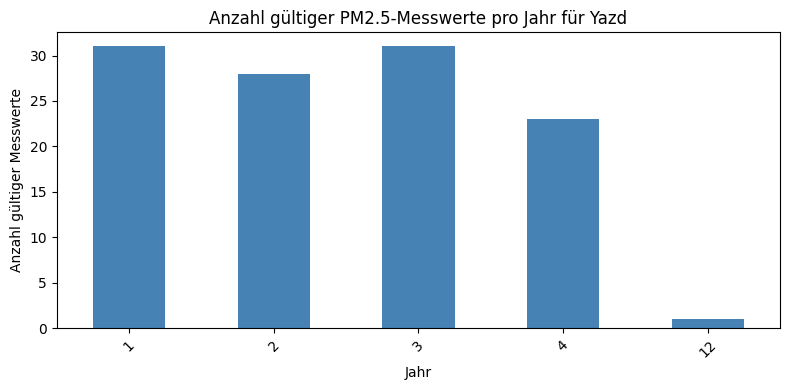

In [11]:
# Nur gültige PM2.5-Werte für Yazd
yazd_pm25 = df[(df['City'] == 'Yazd') & (df['Pm25'].notna())]

# Histogramm der Jahresverteilung
plt.figure(figsize=(8, 4))
yazd_pm25['Month'].value_counts().sort_index().plot(kind='bar', color='steelblue')

plt.title("Anzahl gültiger PM2.5-Messwerte pro Jahr für Yazd")
plt.xlabel("Jahr")
plt.ylabel("Anzahl gültiger Messwerte")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [12]:
# Liste problematischer Städte
rauswerfen = ['Plovdiv', 'Yazd']

# Entferne sie aus df und ggf. df_median
df = df[~df['City'].isin(rauswerfen)]

# Und aus dem aggregierten Mittelwert-Datensatz
df_median = df_median[~df_median.index.isin(rauswerfen)]

Sehr schnelles Zwischenergebnis:

Es gibt nur 3 Städte, die den aktuellen WHO-Anspruch von weniger als 5 µg/m³ erfüllen: Zürich (Schweiz), Plovdiv (Bulgarien), Yazd (Iran). Bei genauerem Hinschauen fällt zusätzlich auf, dass es für Plovidiv nur enen einzigen Messwert gibt, und für Yazd nur sehr wenige. 
Die WHO-Richtline kann also nicht verwendet werden, weil ein Modell damit nicht trainierbar ist - es hat keine zweite Klasse.

Wir nehmen also direkt den Median, gehen also datengetrieben vor.

In [13]:
# Umgang mit NaN-Werten

# Anzahl fehlender Werte pro Spalte
df[["City"] + pollutants].isna().sum()

City         0
Co      630218
No2     285899
O3      372793
Pm10    341808
Pm25    258373
So2     531545
dtype: int64

In [14]:
# Anzahl gültiger Werte pro Stadt und Schadstoff
df.groupby('City')[pollutants].count().sort_values(by='Pm25')


,Co,No2,O3,Pm10,Pm25,So2
City,,,,,,
Abha,575,390,656,585,0,663
Ipoh,0,0,0,0,0,0
Oradea,0,2350,1970,1968,0,2033
Malacca,0,0,0,0,0,0
Iaşi,0,2124,771,2076,0,2768
...,...,...,...,...,...,...
Toronto,5903,5939,5939,0,5939,4909
Québec,5928,5021,5956,0,5956,2330
Montréal,5965,5962,5968,0,5968,5759


In [15]:
# Welche Städte enthalten überhaupt keine Schadstoffwerte?

# Alle Schadstoffspalten
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

# Für jede Stadt zählen, wie viele gültige Werte es insgesamt gibt
valid_counts = df.groupby('City')[pollutants].count()

# Zeige nur Städte mit 0 gültigen Werten in *allen* Schadstoffspalten
no_data_cities = valid_counts[(valid_counts == 0).all(axis=1)]

# Ausgabe
no_data_cities.index.tolist()

['Alor setar',
 'George town',
 'Ipoh',
 'Johor bahru',
 'Klang',
 'Kota bharu',
 'Kuala lumpur',
 'Kuantan',
 'Kuching',
 'Malacca',
 'Miri',
 'Seremban',
 'Taiping']

In [16]:
no_data_cities = [
    'Alor setar', 'George town', 'Ipoh', 'Johor bahru', 'Klang', 'Kota bharu',
    'Kuala lumpur', 'Kuantan', 'Kuching', 'Malacca', 'Miri', 'Seremban', 'Taiping'
]
# Entferne sie aus df und ggf. df_median

# Aus dem Haupt-DataFrame
df = df[~df['City'].isin(no_data_cities)]

# Auch aus df_median entfernen (falls schon berechnet)
df_median = df_median[~df_median.index.isin(no_data_cities)]

In [17]:
df_median.shape

(601, 7)

In [18]:
df_median.head()

,Co,No2,O3,Pm10,Pm25,So2,AirQualityLabel
City,,,,,,,
Abha,6.0,1.0,29.0,10.0,NaN,2.0,0
Abidjan,NaN,NaN,NaN,NaN,65.0,NaN,1
Abu dhabi,0.1,10.8,27.3,71.0,93.0,5.1,1
Accra,NaN,NaN,NaN,NaN,61.0,NaN,1
Adana,3.3,9.0,14.9,30.0,68.0,3.7,1


In [19]:
# Relevante Spalten
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

# Für jede Stadt: Wie viele Mittelwerte sind vorhanden?
df_median['Num_Valid_Pollutants'] = df_median[pollutants].notna().sum(axis=1)

# Übersicht: Wie viele Städte haben wie viele gültige Schadstoffwerte?
coverage_summary = df_median['Num_Valid_Pollutants'].value_counts().sort_index()

# Ergebnis anzeigen
coverage_summary


Num_Valid_Pollutants
1     26
2     21
3     12
4     40
5     98
6    404
Name: count, dtype: int64

Weil das Imputieren von überhaupt nicht vorhandenen Kategorien (Schadstoffen) für eine Stadt eigentlich nicht mehr als "Raten" ist, machen wir das hier nicht und reduzieren die Trainingsdaten auf die 404 Städte, die für alle Schadstoffe Werte gemeldet haben.

In [20]:
# Nur Städte mit allen 6 Schadstoff-Mittelwerten
df_median_complete = df_median[df_median['Num_Valid_Pollutants'] == 6]

In [21]:
df_median_complete.head()

,Co,No2,O3,Pm10,Pm25,So2,AirQualityLabel,Num_Valid_Pollutants
City,,,,,,,,
Abu dhabi,0.1,10.8,27.3,71.0,93.0,5.1,1,6
Adana,3.3,9.0,14.9,30.0,68.0,3.7,1,6
Adapazarı,15.7,12.0,14.3,34.0,63.0,14.6,1,6
Adelaide,1.5,1.4,6.5,12.0,17.0,0.6,0,6
Aguascalientes,5.9,7.5,9.6,32.0,52.0,2.0,1,6


In [22]:
df_median_complete.shape

(404, 8)

In [23]:
features = ['Co', 'No2', 'O3', 'Pm10', 'So2']
X = df_median_complete[features]
y = df_median_complete['AirQualityLabel']

In [24]:
# Wir haben  aktuell 404 Städte in df_median_complete. Davon nehmen wir 80% für das Training und 20% für den Test.
# Wir verwenden den Standard-Trainings-Test-Split von scikit-learn.

# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Modell 1: Logistic Regression

In [25]:
#  Modelltraining
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        35
           1       0.98      0.89      0.93        46

    accuracy                           0.93        81
   macro avg       0.92      0.93      0.93        81
weighted avg       0.93      0.93      0.93        81

[[34  1]
 [ 5 41]]


Wenn wir PM10 als Feature drinlassen, klassifiziert das Modell prima - und das ist auch zu erwarten, weil PM2.5 eine Teilmenge von PM10 ist. Also lassen wir PM10 jetzt mal raus und schauen, was dann passiert:

In [27]:
features_no_PM10 = ['Co', 'No2', 'O3', 'So2']
X = df_median_complete[features_no_PM10]
y = df_median_complete['AirQualityLabel']

In [28]:
# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelltraining
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.86      0.78        35
           1       0.87      0.74      0.80        46

    accuracy                           0.79        81
   macro avg       0.79      0.80      0.79        81
weighted avg       0.80      0.79      0.79        81

[[30  5]
 [12 34]]


In [29]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    30                     5
Tatsächlich Positiv                    12                    34


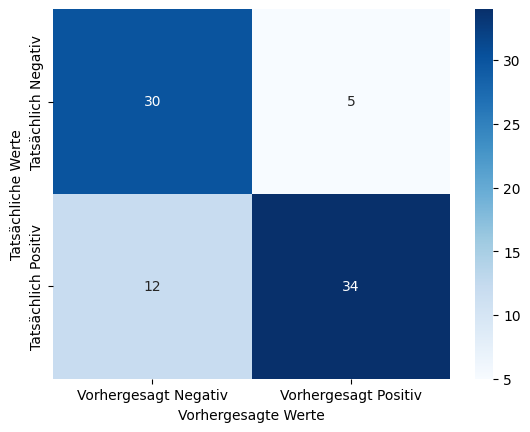

In [30]:
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Tatsächliche Werte")
plt.xlabel("Vorhergesagte Werte");

## 🧾 Entscheidung zur Feature-Auswahl: PM10 aus den Features entfernen

Um die Luftqualität in Städten zu klassifizieren, wurden zunächst alle Schadstoffe (CO, NO₂, O₃, PM10, PM2.5, SO₂) als Features in das Modell aufgenommen, obwohl PM10 und PM2.5 naturgemäß eine hohe Korrelation aufweisen (über 97%).

🔹 Test mit PM10 als Feature:

Das Modell erzielte eine hohe Genauigkeit von 91% und einen sehr hohen F1-Score von 0.92 für die Vorhersage von schlechter Luft (Klasse 1).

Präzision und Recall bei der Klassifikation von „schlechter Luft“ waren sehr hoch (nahe 1.0), was das Modell besonders präzise bei der Vorhersage von schlechter Luft machte.

Allerdings zeigte sich auch, dass das Modell zwischen den Klassen kaum differenzierte, was die klassenspezifische Leistung bei guter Luft (Klasse 0) beeinträchtigte.

🔹 Test ohne PM10 als Feature:

Nachdem PM10 entfernt wurde, ging die Genauigkeit leicht zurück auf 80% und der F1-Score für schlechte Luft sank von 0.92 auf 0.83.

Das Modell zeigt nun jedoch eine ausgewogenere Klassifikation (bevorzogt nicht mehr das Label "schlechte Luft") und ist weniger von redundanten Informationen beeinflusst.

🧠 Ergebnis:

Die Tests haben gezeigt, dass das Modell besser differenziert, wenn PM10 aus den Features entfernt wird. Auch wenn die Gesamtgenauigkeit etwas zurückgeht, ist das Modell nun besser in der Lage, zwischen guter und schlechter Luft zu unterscheiden.
Die Entscheidung, PM10 aus den Features zu entfernen, basiert auf der starken Korrelation mit PM2.5, die zu einer Redundanz führte und das Modell verzerrte.



## Modell 2: Random Forest

In [31]:
# Features and train test split repeated from previous model, just to make clear what is being used:

features_no_PM10 = ['Co', 'No2', 'O3', 'So2']
X = df_median_complete[features_no_PM10]
y = df_median_complete['AirQualityLabel']

# Split in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Random Forest-Modell erstellen
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Modell trainieren
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


In [35]:
# Vorhersagen & Bewertung drucken
print(classification_report(y_test, y_pred_rf))
# print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        35
           1       0.89      0.87      0.88        46

    accuracy                           0.86        81
   macro avg       0.86      0.86      0.86        81
weighted avg       0.86      0.86      0.86        81



In [33]:
cm = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    30                     5
Tatsächlich Positiv                     6                    40


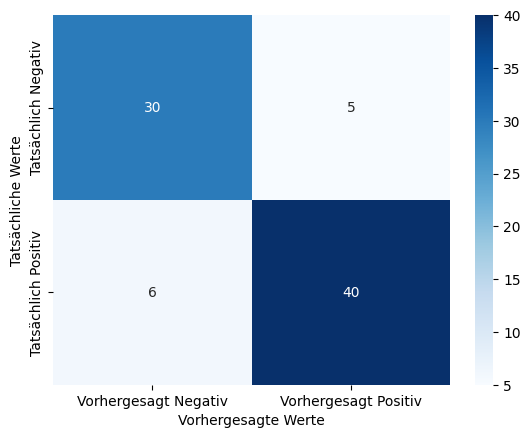

In [34]:
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Tatsächliche Werte")
plt.xlabel("Vorhergesagte Werte");

In [36]:
# Feature importance extrahieren
importances = rf_model.feature_importances_

/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_92539/1345115114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


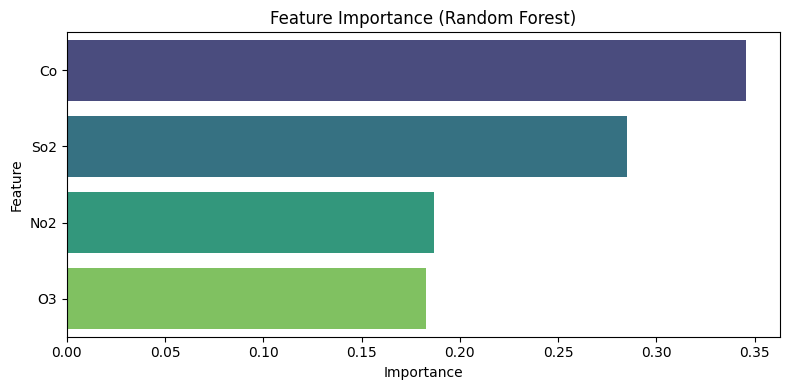

In [37]:
# Feature-Importanz in ein DataFrame umwandeln
feature_importance_df = pd.DataFrame({
    'Feature': features_no_PM10,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Feature-Importanz anzeigen
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



Am wichtigsten für die Klassifizierung ist das Feature "CO". Kann es sein, dass die falsch klassifizierten Städte auffällige CO-Werte haben?

In [38]:
# Falsch klassifizierte Städte finden
incorrect_predictions = X_test.copy()
incorrect_predictions['True Label'] = y_test
incorrect_predictions['Predicted Label'] = y_pred_rf

# Nur falsch klassifizierte Städte herausfiltern
incorrect_predictions = incorrect_predictions[incorrect_predictions['True Label'] != incorrect_predictions['Predicted Label']]

# CO-Werte der falsch klassifizierten Städte
incorrect_predictions['CO'] = X_test.loc[incorrect_predictions.index, 'Co']

# Ausgabe der Städte mit ihren CO-Werten
incorrect_predictions[['True Label', 'Predicted Label', 'CO']]


,True Label,Predicted Label,CO
City,,,
Málaga,0,1,1.8
Budapest,0,1,4.4
Szeged,1,0,2.3
Prato,0,1,0.1
Lampang,1,0,0.1
Nashik,1,0,4.2
Strasbourg,1,0,0.1
Valladolid,0,1,0.1
Kumamoto,1,0,2.3


In [39]:
# CO-Werte der falsch klassifizierten Städte
co_values = incorrect_predictions['CO']

# Berechne die wichtigsten Statistiken (Durchschnitt, IQR)
co_mean = co_values.mean()
co_std = co_values.std()
co_min = co_values.min()
co_max = co_values.max()

# Berechne Interquartilsabstand (IQR)
Q1 = co_values.quantile(0.25)
Q3 = co_values.quantile(0.75)
IQR = Q3 - Q1

# Anzeigen der CO-Statistiken
print(f"Durchschnittlicher CO-Wert: {co_mean:.2f}")
print(f"Standardabweichung: {co_std:.2f}")
print(f"Minimaler CO-Wert: {co_min:.2f}")
print(f"Maximaler CO-Wert: {co_max:.2f}")
print(f"Interquartilsabstand (IQR): {IQR:.2f}")


Durchschnittlicher CO-Wert: 1.86
Standardabweichung: 1.60
Minimaler CO-Wert: 0.10
Maximaler CO-Wert: 4.40
Interquartilsabstand (IQR): 2.45


Hier muss man noch nachdenken, wie man das Modell verbessern kann. Man sollte die falsch zugeordneten Städte überprüfen, ob da mit den Daten was nicht stimmt. Und dann noch die Hyperparameter besser einstellen und so. Nicht mehr heute.

## Modell 3: Gradient Boosting

In [40]:
# Gradient Boosting Modell erstellen
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Modell trainieren
gb_model.fit(X_train, y_train)

# Vorhersagen & Bewertung
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb))
# print(confusion_matrix(y_test, y_pred_gb))


              precision    recall  f1-score   support

           0       0.79      0.89      0.84        35
           1       0.90      0.83      0.86        46

    accuracy                           0.85        81
   macro avg       0.85      0.86      0.85        81
weighted avg       0.86      0.85      0.85        81

[[31  4]
 [ 8 38]]


In [41]:
cm = confusion_matrix(y_test, y_pred_gb)

cm_df = pd.DataFrame(cm, 
                     index=["Tatsächlich Negativ", "Tatsächlich Positiv"], 
                     columns=["Vorhergesagt Negativ", "Vorhergesagt Positiv"])

print(cm_df)

                     Vorhergesagt Negativ  Vorhergesagt Positiv
Tatsächlich Negativ                    31                     4
Tatsächlich Positiv                     8                    38


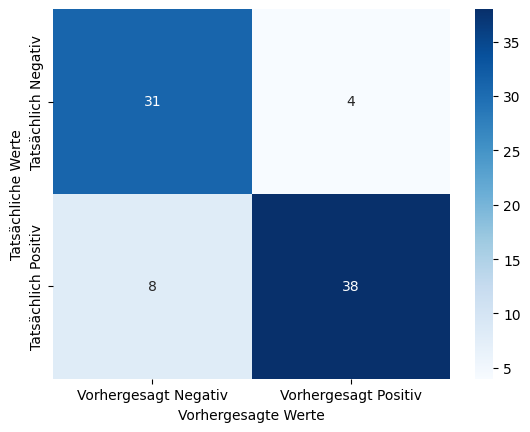

In [42]:
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Tatsächliche Werte")
plt.xlabel("Vorhergesagte Werte");